<h1><b>Statistique en Bioinformatique : </b> TME9 </h1><br>

L’objectif de ce TME est: 
<br>
<ul>
<li> Evaluer la performance des HMMs sur les homologues lointains </li> 
</ul>
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**Soumission**</p>
<ul>
<li>Renomer le fichier TME9.ipynb pour NomEtudiant1_NomEtudiant2_TME9.ipynb </li>
<li>Envoyer par email à edoardo.sarti@upmc.fr, l’objet de l'email sera [SBAS-2019] TME9</li>
</ul>
</div>

Nom etudiant 1 : Alex YE
<br>
Nom etudiant 2 :
<br>

<h2> Datasets </h2><br>
To evaluate the performance of HMMer over remote homologous proteins, we will work with datasets scop-95 and scop-30 having at most 95 and 30% of identity.  We will use a leave-one-out strategy as follows. Given a scop family $F$  in one of the scop datasets, we consider the set of $n$ sequences associated to $F$ in scop, to create $n$ test-sets for $F$. Each test-set takes $n−1$ sequences for training and leaves one sequence out for the test. Then, we test whether the sequence that was left out could be annotated by a HMMer profile constructed without using it, and count the correct identification of the domain as a true positive (TP), the identification of an erroneous domain as a false positive (FP) and the identification of no domain as a false negative (FN). For each scop dataset you can find the directory `aln` that contains the alignment for each testsets in STOCKHOLM format, extension .sto

For scop-95 dataset do:

1\. Create pHMMs from the alignments in `aln/*.sto`. Use the program `hmmbuild` from the HMMer-3 package. Save models  in a directory named models. Put your code below, but run it on the terminal.

In [10]:
import os
import subprocess

tme_path = os.getcwd() 
scop95 = tme_path + '/scop/scop95/' 
aln_scop95 = scop95 + 'aln/'
model_dir = scop95 + 'models/'
  
    
def dir_exists(dir_name):
    return os.path.isdir(dir_name)

def create_dir(dir_name):
    os.mkdir(dir_name)


def do_the_thing( aln_directory, model_directory ):
    MSAs = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(aln_directory):
        for file in f:
            if '.sto' in file:
                MSAs.append(file)
                #MSAs.append(os.path.join(r, file))

    for aln in MSAs:
        name = aln[:-4]
        inp = aln_directory + aln
        outp = model_directory + name +'.hmm'

        #wrap command
        cline = "hmmbuild" + ' ' + outp + ' ' + inp
        #run command
        subprocess.run(list(str(cline).split(' ')))

    print("success !")
    
if(not dir_exists(model_dir)):
    create_dir(model_dir)
#do_the_thing(aln_scop95, model_dir)

2\. Search all sequences in the file `scopTestSeq.fasta` against all models created previously. Use `hmmsearch` and the option `--domtblout` to save parseable table of per-domain hits to file, use option `-E 1`. Save the outputs in a directory named `searchResults/`. Put your code below, but run it on the terminal.

In [22]:
filename_ = 'scop/scopTestSeq.fasta'
search_dir = scop95 + 'searchResults/'

def the_other_thing( sequence_file, model_directory, search_directory):
    models = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(model_directory):
        for file in f:
            if '.hmm' in file:
                models.append(file)
    for model in models:
        name = model[:-4]
        model_file = model_directory + model
        output_name = search_directory + name +'.out'
        option_domtblout = '--domtblout ' + output_name
        option_E = '-E 1'
        
        #wrap command
        cline = "hmmsearch" + ' ' + option_domtblout + ' ' + option_E + ' ' + model_file + ' ' + sequence_file
        #run command
        subprocess.run(list(str(cline).split(' ')))
    print("success !")

if(not dir_exists(search_dir)):
    create_dir(search_dir)
the_other_thing(filename_, model_dir, search_dir)

success !


3\. Concat all search results, rank the sequences and remove all hits having same family and different proteinID. Consider just the best hit per sequence.

```bash
# the following bash commands illustrate a way to concatenate and format the output of hmmsearch
# hmmsearch results are assumed to be in the current directory and in files with extension .out
cat *.out > allRes.txt
sed 's/^#/d' allRes.txt > allRes.txt.ftt
cat allRes.txt.ftt | awk '{print $1" "$4" "$12}' > allRes.txt.ftt.2
sed -i -e 's/\.aln//g' allRes.txt.ftt.2
mv allRes.txt.ftt.2 allRes.txt.ftt
```

In [11]:
#i believe there was an extra s in the second command, so i removed it
''' in directory: scope/scope95/searchResults/
cat *.out > allRes.txt
sed '/^#/d' allRes.txt > allRes.txt.ftt    
cat allRes.txt.ftt | awk '{print $1" "$4" "$12}' > allRes.txt.ftt.2
sed -i -e 's/\.aln//g' allRes.txt.ftt.2
mv allRes.txt.ftt.2 allRes.txt.ftt
'''

file_ = 'scop/scop95/searchResults/allRes.txt.ftt'
dic = {}
with open(file_, 'r') as f:
    #target, query, C-Evalue
    for line in f:
        line = line.strip()
        it = line.split(' ')
        target = it[0]
        query = it[1]
        value = float(it[2])
        
        if( target not in dic ):
            dic[target] = []
        dic[target].append( (query,value) )
    
    
sequence_match95 = []
for k in dic: #pour chaque séquence
    #print(len(dic[k]))
    best_hit = max( dic[k], key= lambda x: x[1] )   #modèle avec le meilleur score pour la séquence
    sequence_match95.append( [k,best_hit[0],best_hit[1]] )
    
    
#format : target, query, C-Evalue
#ranking by value
#lowest to highest
sequence_match95 = sorted( sequence_match95, key= lambda x: x[2] )


real_positives = 0
treshs95 = [] #all possible tresholds, from lowest to highest
for s in sequence_match95:
    if(s[0] == s[1]):
        real_positives += 1
    treshs95.append(s[2])
        
print(real_positives, len(sequence_match95))
        
#highest to lowest
sequence_match95 = sequence_match95[::-1]

329 780



4\. Compute the performance. If a test sequence is better scored by the model associated to its family it is a true positive (TP). If it is scored by a different model it is a false positive (FP). If it is not scored by any model it is a false negative (FN). With this values compute $\text{Precision}=\frac{TP}{TP+FP}$, $\text{Recall} = \frac{TP}{TP+FN}$, and $\text{F-score} = \frac{ 2 \cdot \text{Precision} \cdot \text{Recall} }{ \text{Precision} + \text{Recall} }$.

In [12]:
#/!\ toutes les séquences ont un score. Pas de FN ? 

def test(sequence_match):
    TP = 0
    FP = 0
    FN = 0
    for s in sequence_match:
        target = s[0]
        query = s[1]
        value = s[2]
        
        if(target == query):
            TP += 1
        elif(target != query):
            FP += 1
        else :
            FN += 1
            
    return TP,FP,FN
            

precision = lambda tp,fp : tp/(tp+fp)
recall = lambda tp,fn : tp/(tp+fn)
fscore = lambda p,r :(2*p*r)/(p+r)
true_pos_rate = lambda tp,fn : tp/(tp+fn)
false_pos_rate = lambda fp, tn: fp/(fp+tn)


TP,FP,FN = test(sequence_match95)
P = precision(TP,FP)
R = recall(TP,FN)
F = fscore(P,R)

P,R,F

(0.4217948717948718, 1.0, 0.5933273219116321)

5\.Roc curve https://en.wikipedia.org/wiki/Receiver_operating_characteristic. We can plot curves to observe the performance of a tool under different conditions. For that, we range the score (E-value) and we compute true positive rate (Y axis) and false positive rate (X-axis) measures for each value. Write a python script to construct the Roc curve based on the results obtained before.

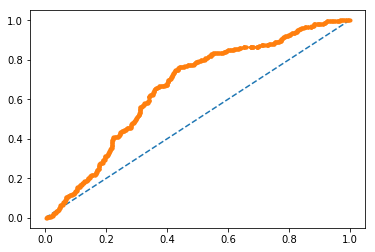

In [13]:
import matplotlib.pyplot as plt 

def run_test(sequence_match, treshs):
    TPR = []
    FPR = []
    PRC = []
    REC = []
    for t in treshs:
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for s in sequence_match:
            target = s[0]
            query = s[1]
            value = s[2]
            
            if(value <= t):
                predict = True
            else:
                predict = False
            if(target == query and predict):
                tp += 1 
            elif(target != query and predict):
                fp += 1
            elif(target == query and not predict):
                fn += 1
            else:
                tn += 1
                
        #print(tp,fp,tn,fn)
        
        TPR.append( true_pos_rate(tp,fn) )
        FPR.append( false_pos_rate(fp,tn) )
        PRC.append( precision(tp,fp) )
        REC.append( recall(tp,fn) )
        
    return TPR, FPR, PRC, REC
    
TPR, FPR, PRC, REC = run_test(sequence_match95, treshs95)   

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( FPR, TPR, marker='.')
plt.show()



6\. Write a python script to plot the Precision/recall curve. We can use the same strategy of Roc curve to compute the precision  (Y axis)  and recall  (X axis)  curves.

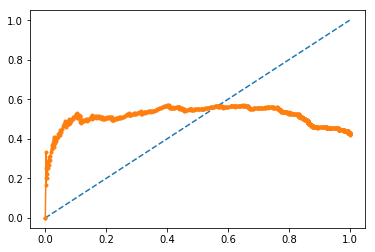

In [174]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( REC, PRC, marker='.')
plt.show()

7\. Repeat steps 1 to 6 also for the scop-30 dataset and compare the curves obtained for the two SCOP datasets, what is your conclusion? Include the curves in your answer.

In [176]:
tme_path = os.getcwd() 
scop30 = tme_path + '/scop/scop30/' 
aln_scop30 = scop30 + 'aln/'
model_dir = scop30 + 'models/'
filename_ = 'scop/scopTestSeq.fasta'
search_dir = scop30 + 'searchResults/'


if(not dir_exists(model_dir)):
    create_dir(model_dir)

if(not dir_exists(search_dir)):
    create_dir(search_dir)
    
#time consuming
do_the_thing(aln_scop30, model_dir)
the_other_thing(filename_, model_dir, search_dir)



####################
# enter commands into terminal
''' in directory: scope/scope30/searchResults/
cat *.out > allRes.txt
sed '/^#/d' allRes.txt > allRes.txt.ftt    
cat allRes.txt.ftt | awk '{print $1" "$4" "$12}' > allRes.txt.ftt.2
sed -i -e 's/\.aln//g' allRes.txt.ftt.2
mv allRes.txt.ftt.2 allRes.txt.ftt
'''
####################

success !
success !


In [14]:
file_ = 'scop/scop30/searchResults/allRes.txt.ftt'
dic = {}
with open(file_, 'r') as f:
    #target, query, C-Evalue
    for line in f:
        line = line.strip()
        it = line.split(' ')
        target = it[0]
        query = it[1]
        value = float(it[2])
        
        if( target not in dic ):
            dic[target] = []
        dic[target].append( (query,value) )
    
    
sequence_match30 = []
for k in dic: #pour chaque séquence
    #print(len(dic[k]))
    best_hit = max( dic[k], key= lambda x: x[1] )   #modèle avec le meilleur score pour la séquence
    sequence_match30.append( [k,best_hit[0],best_hit[1]] )
    
    
#format : target, query, C-Evalue
#ranking by value
#lowest to highest
sequence_match30 = sorted( sequence_match30, key= lambda x: x[2] )


real_positives = 0
treshs30 = [] #all possible tresholds, from lowest to highest
for s in sequence_match30:
    if(s[0] == s[1]):
        real_positives += 1
    treshs30.append(s[2])

print(real_positives, len(sequence_match30))
        
#highest to lowest
sequence_match30 = sequence_match30[::-1]


TP,FP,FN = test(sequence_match30)
P = precision(TP,FP)
R = recall(TP,FN)
F = fscore(P,R)

P,R,F

308 787


(0.39135959339263027, 1.0, 0.5625570776255708)

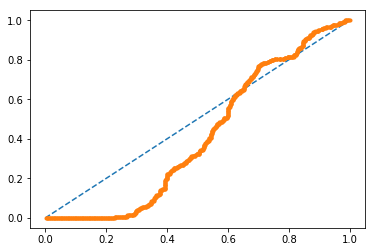

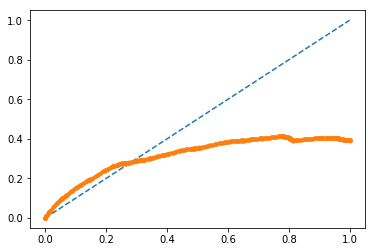

In [9]:
TPR, FPR, PRC, REC = run_test(sequence_match30, treshs30)   

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( FPR, TPR, marker='.')
plt.show()


plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( REC, PRC, marker='.')
plt.show()

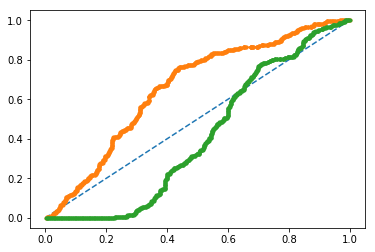

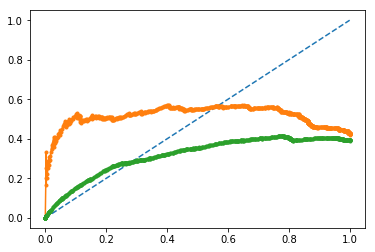

In [21]:
#sur le même graph

TPR95, FPR95, PRC95, REC95 = run_test(sequence_match95, treshs95)   
TPR30, FPR30, PRC30, REC30 = run_test(sequence_match30, treshs30)  

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( FPR95, TPR95, marker='.')
plt.plot( FPR30, TPR30, marker='.')
plt.show()


plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( REC95, PRC95, marker='.')
plt.plot( REC30, PRC30, marker='.')
plt.show()

In [22]:
'''

On obtient une courbe ROC relativement bonne avec le jeu de donné à 95% d'identité (en orange)
On remarque que la courbe roc pour le jeu de donnée à 30% d'identité (en vert) est plus mauvais que la précédente
et même plus mauvaise que l'aléatoire estimé par la droite en pointillé bleu. 
La seconde courbe n'est donc pas exploitable. 

On en déduit que le taux d'identité du jeu de donnée étudié doit être très élevé pour aboutir à un résultat utile.

'''